## Introduction

Recently I read the excellent tutorial [Deep Learning and Medical Image Analysis with Keras](https://www.pyimagesearch.com/2018/12/03/deep-learning-and-medical-image-analysis-with-keras/) by Dr. Adrian Rosebrock's. Adrian's tutorial shows how to use a pre-trained [ResNet](https://arxiv.org/abs/1512.03385) neural network to build a binary classifier that can categorise whether cell images are infected with the malaria parasite. Such a system can then be used to compute the percentage of infected red blood cells in a thin blood smear slide to determine whether a patient's blood sample is infected with malaria.

In the tutorial Adrian successfully builds a simpler and more efficient model that nearly matched the malaria detection performance reported in the [NIH](https://www.nih.gov/) paper by Rajaraman et al., [Pre-trained convolutional neural networks as feature extractors toward improved malaria parasite detection in thin blood smear images](https://ceb.nlm.nih.gov/abstract/?title=Pre-trained+convolutional+neural+networks+as+feature+extractors+toward+improved+malaria+parasite+detection+in+thin+blood+smear+images.), 97% vs. 98.6% accuracy respectively. Adrian was also able to train the model in 54 minutes compared to nearly 24 hours in the NIH paper ([pdf link](https://lhncbc.nlm.nih.gov/system/files/pub9752.pdf)) in which six convolutional models, including a custom model, were trained.

The NIH paper was also what motivated Dr. Carlos Atico Ariza and Dr. Johnson Thomas to attempt to build more efficient models that match the performance reported in the paper by Rajaraman et al. In [Malaria Hero: A web app for faster malaria diagnosis](https://blog.insightdatascience.com/https-blog-insightdatascience-com-malaria-hero-a47d3d5fc4bb), Carlos builds two models, one using OpenCV feature engineering and a Random Forest classifier and another that extracts 2048 features using an Inception v3 trained on ImageNet that then feeds the top 100 components after PCA to an L2 regularized logistic regression model, achieving an F2-score of 0.8 and 0.92 respectively. In [Diagnose malaria from cellphone captured microscopic images using Fastai library and Turicreate](https://towardsdatascience.com/diagnose-malaria-from-cellphone-captured-microscopic-images-using-fastai-library-and-turicreate-ae0e27d579e6?fbclid=IwAR2vT1z9fhP08zFH5e8J34ppnJTFzNROrnfQy2m39S9xSqGm_Lisg0Bfpxc), Johnson builds a ResNet based model using the fast.ai library, achieving 97.1% accuracy.

Matching classifier performance using a more computationally efficient model makes it possible to deploy such systems on devices with limited resources (compute and power), such as mobile devices, without requiring access to cloud services. This is crucial for deployment in the field, especially when these systems are mostly required in remote areas of the world where malaria is still prevalent and a major cause of mortality.

This motivated me to try and build a model using as few features as possible that could still match the performance reported above. Such a lightweight model would make it even more feasible to run on mobile devices for deployment where it is most required.

## Machine Used for Experimentation

This notebook and all experiments were carried out in a Docker container started as a Jupyter Notebook server, using the [Anaconda 3 Docker image](https://hub.docker.com/r/continuumio/anaconda3/).

If you want to reproduce my work or experiment with other features or models, you can download a copy of this notebook from [GitHub](https://github.com/stefanfiott/malaria-detection-using-svm).

## Importing Required Libraries

First, we import the libraries required to carry out our work.

* `matplotlib` and `seaborn` to view cell images and plot some graphs
* iPython widgets to show progress bars for lengthy operations
* basic python `os` and `math` functionality
* `numpy` and `random` to manipulate arrays and generate random numbers
* scikit-image, `skimage`, to read cell image files and process them as required
* scikit-learn, `sklearn`, to carry feature engineering, model fitting and hyperparameter searching

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
%matplotlib inline
import seaborn as sns

from ipywidgets import IntProgress
from IPython.display import display

from os import listdir, path
from math import floor

import numpy as np
import random

# set random seeds to aid reproducibility
random.seed(22)
np.random.seed(22)

from skimage import io, color
from skimage.transform import resize

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import svm, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Constants and Helper Functions

The following are just some constants and functions that are used throughout the notebook. If you downloaded a copy of this notebook and are trying it out yourself, make sure to change the `malaria_dataset_path` to specify the location where you uncompressed the malaria dataset zip file.

In [2]:
malaria_dataset_path = '/home/datasets/CV/malaria/cell_images/'
parasitized_dir = 'Parasitized'
uninfected_dir = 'Uninfected'
default_ext = '.npy'

def initialize_progress_bar(max_count):
    '''
        Initializes a progress bar with range from
        0 to max_count and returns it.
        
        By setting the value of the progress bar
        returned one can visualise the progress of 
        lengthy processes.
    '''
    
    f = IntProgress(min=0, max=max_count)
    display(f)
    f.value = 0
    return f

def save_data(data, save_file_path, data_type='float32'):
    '''
        Convert the contents of the numpy array specified 
        in data to the data type specified in data_type, 
        by default float32, and then save to disk in the 
        path specified in save_file_path.
    '''
    
    print('Saving file {0}...'.format(save_file_path))
    data = data.astype(data_type)
    np.save(save_file_path, data, allow_pickle=False, fix_imports=False)
    print('Done.')
    return data

def load_data(file_path):
    '''
        Load a numpy array from the file located at 
        file_path and return it.
    '''
    
    data = np.load(file_path)
    return data

## Malaria Dataset

We will use the same malaria dataset used in all the other experiments mentioned in the introduction section above. The malaria dataset is composed of a total of 27,598 segmented cell images extracted from thin blood smear slide images. The cell images are organized into two folders, parasitized and uninfected, with 13,799 cell images in each, making this a balanced dataset.

Thanks to the National Institute of Health (NIH) the malaria dataset is available for download from [https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip](https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip).

### Visualise Parasitized vs Uninfected Cells

We now visualise the first five cell images from each of the parasitized and uninfected folders to get an idea of what these images look like.

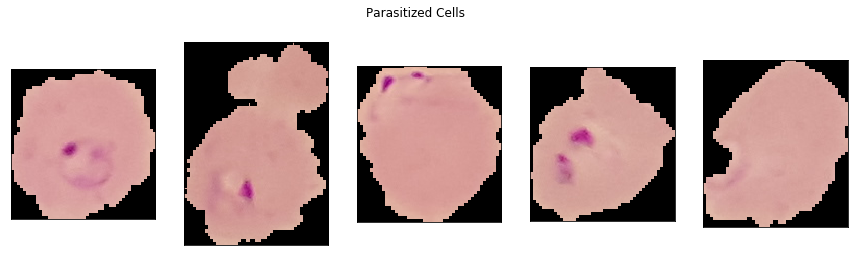

In [3]:
def show_sample_cells(cell_type, num_cells=5, greyscale=False, resize_image=False):
    fig, axes = plt.subplots(1, num_cells, figsize=(15,4))
    fig.suptitle('{0} Cells{1}{2}'.format(cell_type, 
                                          ' - Greyscale' if greyscale else '',
                                          ' - 50x50' if resize_image else ''))
    for idx, f in enumerate(listdir(path.join(malaria_dataset_path, cell_type))[:5]):
        cell_image = io.imread(path.join(malaria_dataset_path, cell_type, f))
        if resize_image:
            cell_image = resize(cell_image, (50, 50, cell_image.shape[2]), mode='reflect')
        if greyscale:
            cell_image = color.rgb2grey(cell_image)
            axes[idx].imshow(cell_image, cmap='gray')
        else:
            axes[idx].imshow(cell_image)
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        
show_sample_cells(parasitized_dir)

In the first four parasitized cells, one or more purple blobs can be seen. This is the malaria parasite stained with a contrasting agent. In the fifth parasitized cell image, the staining is not as evident, although there is a semicircular light purple border in the bottom left of the image.

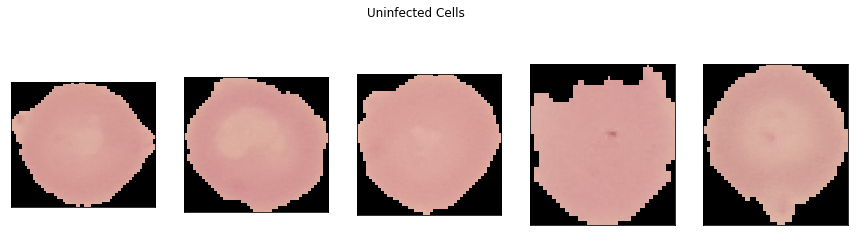

In [4]:
show_sample_cells(uninfected_dir)

In contrast, the five uninfected cell images do not show staining, although the fourth and fifth uninfected cell images do have a very light and small purple stain near the middle.

### Clinical Method to Detect Malaria

To determine whether a person is infected with malaria, a clinician would manually count the number of infected cells present in a thin blood smear slide image using a microscope. This is a very time consuming and tiring process and unless the clinician is highly trained and carries out this type of exercise frequently, it is also a process prone to errors.

Computers can help with this since they do not get tired and can count and process thin blood smear slide images in a fraction of the time a clinician needs, which means more blood samples can be processed in less time. If done accurately and reliably, such a computer system would enable more people to be tested. Diagnosing more people and giving them the necessary medical attention can save many lives.

So it seems like to determine whether a red blood cell is infected, a clinician mostly relies on seeing a contrasting agent stain, irrespective of its shape or location within the image. To determine the specific type of malaria parasite infection other factors need to be considered, but in this experiment we are focusing solely on determining whether a cell is infected with the malaria parasite, not which specific variant it is.

## Feature Engineering

In this experiment, we will not use convolutional neural networks, for the following couple of reasons.

Firstly, because as outlined in the introduction section a lot of work has already been done in this area using pre-trained models such as ResNet and Inception v3 trained on ImageNet. These models achieved very good accuracy results but they still take quite some time to train. In Adrian's work training took approximately 54 minutes on a machine using a single Titan X GPU. Runtime costs are not clear, but loading even a modest 10-17MB parameter model and doing a forward pass for inference is still computationally more expensive than a simple model such as an SVM.

Secondly, convolutional networks perform automatic feature extraction and these will include shape detection amongst others. For this experiment these are not required because we want to test whether very simple features are enough to build a lightweight binary malaria detection classifier.

Since we are not going to use neural networks we have to do some basic feature extraction and engineering. The features we extract do not need to encode the shape of the stain or its location. There also does not seem to be a need to count the number of stains present in the cell image.

Based on the way a clinician determines whether a cell is infected, presence or absence of stained areas, a possible approach is to distinguish between classes based on the distribution of colours present in the image. To simplify the problem even further let us see how the first five cell images from each class look in greyscale. If we still can visually determine parasitized cells from uninfected cells in greyscale, then we can further reduce the dimensionality of our problem.

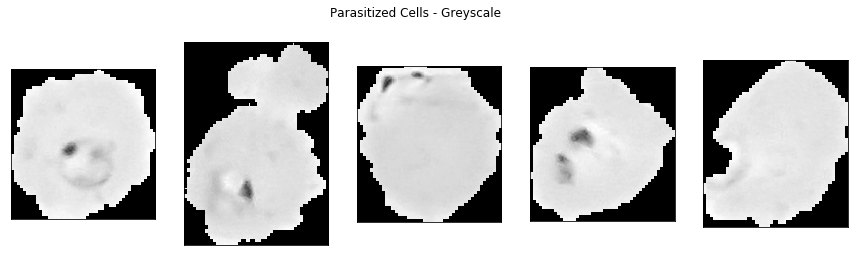

In [5]:
show_sample_cells(parasitized_dir, greyscale=True)

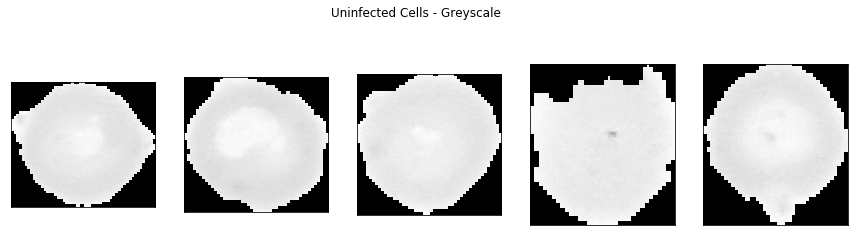

In [6]:
show_sample_cells(uninfected_dir, greyscale=True)

Parasitized cells can still be distinguished visually from uninfected cells using greyscale. Therefore, we will process the malaria dataset to convert all images to greyscale. Furthermore, from the cell images above we can see that the width and height of the images varies and thus we need to standardise the cell image sizes by resizing them.

Before processing the whole malaria dataset let us see how the above ten greyscale images will look like when resized to 50x50 pixels images.

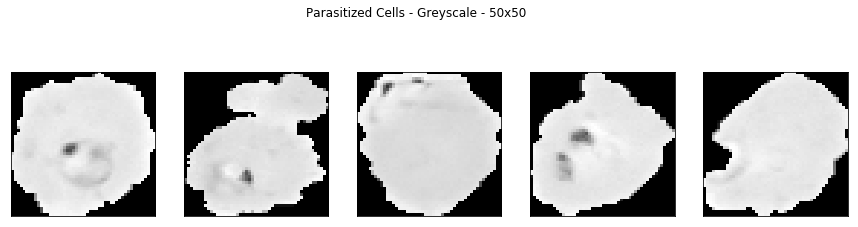

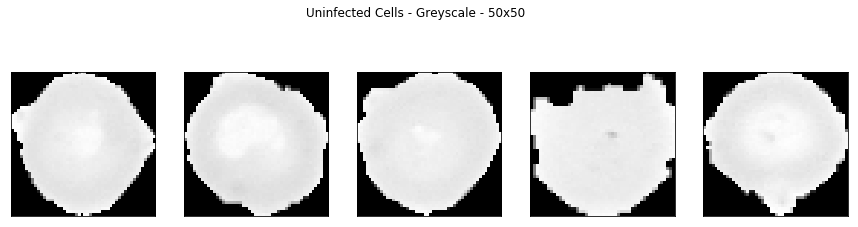

In [7]:
show_sample_cells(parasitized_dir, greyscale=True, resize_image=True)
show_sample_cells(uninfected_dir, greyscale=True, resize_image=True)

Both types of cell images look good and retain the staining features we are interested in after resizing them to 50x50 pixels.

### Extracting Distribution of Colours in an Image

After we resize and greyscale the images we need to extract our feature, which is an approximation of a distribution of colours in the image. The idea behind this being that parasitized and uninfected cell images have different colour distributions due to the staining caused by the presence of malaria parasites and so we can use this property to discriminate between images and classify them accordingly.

To do this after resizing an image to 50x50 pixels and converting it to greyscale, we will use NumPy's `histogram` function to bin the colours, that range from 0 (black) to 1 (white), into ten bins. After binning the colours we divide the count in each bin by the sum of the counts, so that in each bin we have a normalized value between 0 and 1 inclusive.

Note that we specify the range as being from 0.1 to 1 in the `histogram` function. This is done so that the background noise present outside the segmented cell, the black pixels, are not taken into consideration and so do not affect the distribution of colours.

### Processing Malaria Dataset

Since the malaria dataset is made up of 27,598 individual image files we want to process them once and store the intermediate and final results as large NumPy arrays. These NumPy arrays can then be saved to disk and loaded much more efficiently when required instead of accessing thousands of individual files.

The `load_histnorm_data` function below takes care of processing all image files present in the malaria dataset folder specified. Each image is resized to 50x50 pixels using the `resize_cell_images` function, converted to greyscale using the `greyscale_cell_images` function and a normalized histogram of colours computed using the `histnorm_cell_images` function. At each stage, intermediate NumPy array files are saved as required to speed up loading in the future.

In [8]:
def resize_cell_images(cell_images_path):
    cell_image_files = listdir(cell_images_path)
    cell_image_files = [f for f in cell_image_files if f.endswith('.png')]
    cell_image_files.sort()
    
    num_cell_images = len(cell_image_files)
    f = initialize_progress_bar(num_cell_images)
    data = np.zeros((num_cell_images,50,50,3))
    for idx, cell_image_file in enumerate(cell_image_files):
        cell_image = io.imread(path.join(cell_images_path, cell_image_file))
        cell_image_resized = resize(cell_image, (50, 50, cell_image.shape[2]), mode='reflect')
        data[idx] = cell_image_resized
        f.value += 1
    data = data.astype('float32')
    return data

def greyscale_cell_images(data):
    f = initialize_progress_bar(data.shape[0])
    gs_data = np.zeros((data.shape[0],50,50))
    for idx, cell_image in enumerate(data):
        gs_data[idx] = color.rgb2grey(cell_image)
        f.value += 1
    gs_data = gs_data.astype('float32')
    return gs_data

def histnorm_cell_images(data):
    f = initialize_progress_bar(data.shape[0])
    hn_data = np.zeros((data.shape[0],10))
    for idx, cell_image in enumerate(data):
        # range starts from 0.1 to eliminate all black background, value 0
        counts, bins = np.histogram(cell_image, bins=10, range=(0.1,1))
        hn_data[idx] = counts / np.sum(counts)
        f.value += 1
    hn_data = hn_data.astype('float32')
    return hn_data

def load_histnorm_data(cell_types):    
    print('Loading {0}...'.format(cell_types))
    
    histnorm_data_file_path = path.join(malaria_dataset_path, ''.join(['hn_', cell_types, default_ext]))
    if path.isfile(histnorm_data_file_path):
        print('Loading histnorm data...')
        histnorm_data = load_data(histnorm_data_file_path)
    else:
        greyscaled_cell_images_data_file_path = path.join(malaria_dataset_path, ''.join(['gs_', cell_types, default_ext]))
        if path.isfile(greyscaled_cell_images_data_file_path):
            print('Loading greyscaled cell images...')
            greyscaled_cell_images_data = load_data(greyscaled_cell_images_data_file_path)
        else:
            resized_cell_images_data_file_path = path.join(malaria_dataset_path, ''.join(['rs_', cell_types, default_ext]))
            if path.isfile(resized_cell_images_data_file_path):
                print('Loading resized cell images...')
                resized_cell_images_data = load_data(resized_cell_images_data_file_path)
            else:
                print('Resizing cell images...')
                resized_cell_images_data = resize_cell_images(path.join(malaria_dataset_path, cell_types))
                resized_cell_images_data = save_data(resized_cell_images_data, resized_cell_images_data_file_path)
                
            print('Greyscaling cell images...')
            greyscaled_cell_images_data = greyscale_cell_images(resized_cell_images_data)
            greyscaled_cell_images_data = save_data(greyscaled_cell_images_data, greyscaled_cell_images_data_file_path)
            
        print('Histnorming cell images...')
        histnorm_data = histnorm_cell_images(greyscaled_cell_images_data)
        histnorm_data = save_data(histnorm_data, histnorm_data_file_path)
        
    return histnorm_data

### Visualising the Normalized Colour Histogram Data

Let us now visualise the normalized colour histogram data for both parasitized and uninfected cell images. Since we have 10-dimensional vectors we cannot visualize them in full and so instead we will plot a 2D and 3D scatter plot using the first two and three componets respectively.

In [9]:
def plot_data_scatter(parasitized_data, uninfected_data):
    if (
         parasitized_data.shape[1] >= 2 and
         uninfected_data.shape[1] >= 2
       ):
        # plot top two components
        plt.scatter(parasitized_data[:,0],
                    parasitized_data[:,1],
                    color='navy',
                    alpha=0.5,
                    label='Parasitized')
        plt.scatter(uninfected_data[:,0],
                    uninfected_data[:,1],
                    color='darkorange',
                    alpha=0.5,
                    label='Uninfected')
        plt.legend()

    if (
         parasitized_data.shape[1] >= 3 and
         uninfected_data.shape[1] >= 3
       ):
        # plot top three components
        fig = plt.figure(figsize=(9,5))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(parasitized_data[:,0],
                   parasitized_data[:,1],
                   parasitized_data[:,2],
                   color='navy',
                   alpha=0.5,
                   label='Parasitized')
        ax.scatter(uninfected_data[:,0],
                   uninfected_data[:,1],
                   uninfected_data[:,2],
                   color='darkorange',
                   alpha=0.5,
                   label='Uninfected')
        ax.legend()
        
    plt.show()

Loading Parasitized...
Loading histnorm data...
Loading Uninfected...
Loading histnorm data...


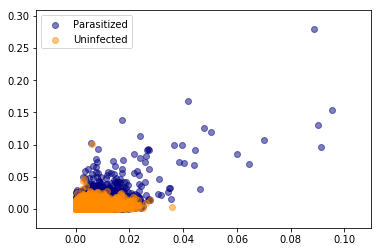

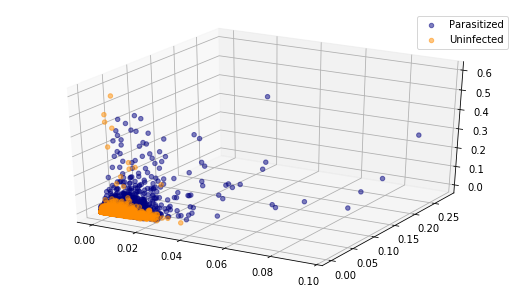

In [10]:
parasitized_histnorm_data = load_histnorm_data(parasitized_dir)
uninfected_histnorm_data = load_histnorm_data(uninfected_dir)
plot_data_scatter(parasitized_histnorm_data, uninfected_histnorm_data)

Visualising only these two or three components it is evident that there is no line or plane that can separate this data. So we will need to use a non-linear classifier such as an SVM with an RBF kernel to discriminate between parasitized and uninfected cell images.

## Creating and Loading Training and Testing Data

Now that we have functionality to preprocess the malaria dataset and extract normalized colour histograms, we can write the functionality to split the data into a training set and a testing set. The `load_datasets` function takes care of loading the training and testing data from files if present. If not, it calls the appropriate functions to load the normalized colour histogram data, split into training and testing sets and save the relevant files to disk. The functions also ensure that splitting is done randomly and that classes are balanced in both training and testing datasets.

In [11]:
def _add_class(data, positive_class=False):    
    if positive_class:
        new_data = np.ones((data.shape[0], data.shape[1]+1))
    else:
        new_data = np.zeros((data.shape[0], data.shape[1]+1))
    new_data[:,:-1] = data[:,:]
    return new_data

def _create_training_testing_split(parasitized_class_data, uninfected_class_data, training=0.8):
    '''
        training: default to 80% of data
        testing: remaining data
    '''
    
    # equal count of parasitized and uninfected records in the malaria dataset
    assert parasitized_class_data.shape[0] == uninfected_class_data.shape[0]
    
    num_samples_in_each_class = parasitized_class_data.shape[0]
    num_features_plus_class = parasitized_class_data.shape[1]
    
    print('{0} samples in each class with {1} features.'.format(num_samples_in_each_class,
                                                                num_features_plus_class-1))
    
    training_count = floor(num_samples_in_each_class * training)
    testing_count = num_samples_in_each_class - training_count
    
    print('Splitting into {0} training and {1} testing samples.'.format(training_count,
                                                                        testing_count))
    
    # Create random training / testing index masks for parasitized / uninfected data
    # so as to split data randomly into training and testing sets.
    parasitized_testing_indices = random.sample(range(0, num_samples_in_each_class), testing_count)
    parasitized_training_mask = np.ones(num_samples_in_each_class, dtype=bool)
    parasitized_training_mask[parasitized_testing_indices] = False
    uninfected_testing_indices = random.sample(range(0, num_samples_in_each_class), testing_count)
    uninfected_training_mask = np.ones(num_samples_in_each_class, dtype=bool)
    uninfected_training_mask[uninfected_testing_indices] = False
    
    # creating training data set
    training_data = np.zeros((training_count*2, num_features_plus_class))
    training_data[:training_count,:] = parasitized_class_data[parasitized_training_mask]
    training_data[training_count:,:] = uninfected_class_data[uninfected_training_mask]
    
    testing_data = np.zeros((testing_count*2, num_features_plus_class))
    testing_data[:testing_count,:] = parasitized_class_data[~parasitized_training_mask]
    testing_data[testing_count:,:] = uninfected_class_data[~uninfected_training_mask]
    
    # shuffle rows
    np.random.shuffle(training_data)
    np.random.shuffle(testing_data)
    
    return training_data, testing_data

def _create_training_testing_data():
    print('Creating training and testing data files...')
        
    print('Loading histnormed data...')
    parasitized_histnorm_data = load_histnorm_data(parasitized_dir)
    uninfected_histnorm_data = load_histnorm_data(uninfected_dir)

    print('Extracting features from data...')
    parasitized_class_data = _add_class(parasitized_histnorm_data, positive_class=True)
    uninfected_class_data = _add_class(uninfected_histnorm_data)

    print('Splitting data into training and testing data sets...')
    training_data, testing_data = _create_training_testing_split(parasitized_class_data,
                                                                 uninfected_class_data)
    
    assert np.sum(training_data[:,-1:]) == len(training_data)/2, "Training data is not balanced."
    assert np.sum(testing_data[:,-1:]) == len(testing_data)/2, "Testing data is not balanced."
    
    print('Done.')
    
    return training_data, testing_data
    
def load_datasets():
    training_file_path = path.join(malaria_dataset_path, ''.join(['training', default_ext]))
    testing_file_path = path.join(malaria_dataset_path, ''.join(['testing', default_ext]))
    
    if path.isfile(training_file_path) and path.isfile(testing_file_path):
        print('Loading training and testing data...')
        training_data = load_data(training_file_path)
        testing_data = load_data(testing_file_path)
        print('Done.')
    else:
        training_data, testing_data = _create_training_testing_data()
        
        print('Saving training and testing data sets...')
        training_data = save_data(training_data, training_file_path)
        testing_data = save_data(testing_data, testing_file_path)
        print('Done.')
        
    X_train = training_data[:,:-1]
    y_train = training_data[:,-1:]
    y_train = y_train.reshape([y_train.shape[0],])
    X_test = testing_data[:,:-1]
    y_test = testing_data[:,-1:]
    y_test = y_test.reshape([y_test.shape[0],])
        
    return X_train, y_train, X_test, y_test

In [12]:
X_train, y_train, X_test, y_test = load_datasets()

Loading training and testing data...
Done.


## Hyperparameter Tuning an SVM Model

We will now use a grid search to fit multiple SVM models on the training data to determine the best `gamma` and `C` (cost) hyperparameters for an RBF kernel. Instead of a validation set we are going to use cross validation, which will be stratified to ensure a balanced dataset within each fold.

Also, before we fit each model we are going to preprocess the training data to standardize it and transform it using its principal componenets. For this reason we need to use a pipeline.

### Determining Number of Principal Components to Use

Before we perform the grid search let us determine how many principal components we need to cover at least 95% of the variance.

Loading training and testing data...
Done.


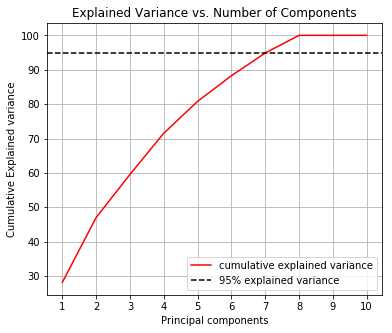

In [13]:
X_train, y_train, X_test, y_test = load_datasets()
scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train)

pca = PCA()
pca.fit(X_train_stand)
cum_exp_var = pca.explained_variance_ratio_.cumsum()*100
d = [n for n in range(1, len(cum_exp_var)+1)]
plt.figure(figsize=(6, 5))
plt.xticks(d)
plt.grid(True, which='both')
plt.plot(d, cum_exp_var, color = 'red',label='cumulative explained variance')
plt.title('Explained Variance vs. Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% explained variance')
plt.legend(loc='best')
plt.show()

From this chart we determine that 7 principal components explain 95% of the variance.

### Creating a Pipeline to Run a Grid Search

We now create a pipeline so that on each fold we standardize the data and transform it using PCA. The PCA transformation will be limited to 7 principal components since these explain 95% of the variance.

In [15]:
def perform_grid_search(C_range, gamma_range):
    X_train, y_train, X_test, y_test = load_datasets()
    
    scaler = StandardScaler()
    pca = PCA(n_components=7)
    svc = svm.SVC()
    pipe = Pipeline([('scaler',scaler),
                     ('pca',pca),
                     ('svc',svc)])

    param_grid = {'svc__C': C_range,
                  'svc__gamma': gamma_range}

    search = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5), n_jobs=-1, verbose=2)
    search.fit(X_train, y_train)
    
    return search

In [ ]:
C_range = 10. ** np.arange(-1, 3)
gamma_range = 10. ** np.arange(-1, 3)

search = perform_grid_search(C_range, gamma_range)

### Best SVM Hyperparameters

We will now plot a heatmap grid of cost vs. gamma to visualise the best performing combination of hyperparameters based on accuracy. Although accuracy is not usually recommended for medical applications, where sensitivity and specificty are more appropriate, for tuning hyperparameters it suffices, especially since the dataset is balanced.

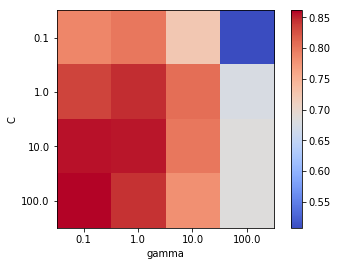

Best accuracy 0.861 using params: {'svc__C': 100.0, 'svc__gamma': 0.1}
Accuracy 95% confidence interval: 0.855 - 0.867


In [67]:
scores = search.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))
plt.figure(figsize=(6, 4))
plt.imshow(scores, cmap=plt.cm.coolwarm)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()
print('Best accuracy {0:.3f} using params: {1}'.format(search.best_score_, search.best_params_))
best_accuracy_std = search.cv_results_['std_test_score'][search.best_index_]
print('Accuracy 95% confidence interval: {0:.3f} - {1:.3f}'.format(search.best_score_ - (best_accuracy_std*2),
                                                           search.best_score_ + (best_accuracy_std*2)))

The above heatmap shows that within the range of `gamma` and `C` combinations explored through grid search, the highest mean accuracy of 86.1% was achieved using `gamma=0.1` and `C=100`. Let us now train the SVM model with RBF kernel using the best performing hyperparameters on the full training set and evaluate its performance on the testing set.

## Fitting Final Model and Evaluating on Testing Set

The final step is to evaluate the SVM model with RBF kernel and hyperparameters set to `gamma=1` and `C=100` on the testing set to get an estimate of the performance on unseen data.

### Training the Best Performing SVM Model on Full Training Set

In [14]:
X_train, y_train, X_test, y_test = load_datasets()

scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train)
X_test_stand = scaler.transform(X_test)

pca = PCA(n_components=7)
pca.fit(X_train_stand)
pca_X_train = pca.transform(X_train_stand)
pca_X_test = pca.transform(X_test_stand)

clf = svm.SVC(kernel='rbf', gamma=1, C=100)
clf.fit(pca_X_train, y_train)

Loading training and testing data...
Done.


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Classifying Cell Images in Testing Set

In [15]:
predictions = clf.predict(pca_X_test)

Accuracy: 0.854
Matthews CC: 0.708
F1 Score: 0.851
Sensitivity: 0.835
Specificity: 0.868


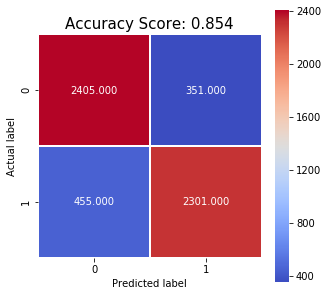

In [22]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
TP, FP, FN, TN = confusion_matrix.ravel()

specificity = TN / (TN + FP) # True Negative Rate

plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = plt.cm.coolwarm);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.3f}'.format(metrics.accuracy_score(y_test, predictions))
plt.title(all_sample_title, size = 15);

print('Accuracy: {0:.3f}'.format(metrics.accuracy_score(y_test, predictions)))
print('Matthews CC: {0:.3f}'.format(metrics.matthews_corrcoef(y_test, predictions)))
print('F1 Score: {0:.3f}'.format(metrics.f1_score(y_test, predictions)))
print('Sensitivity: {0:.3f}'.format(metrics.recall_score(y_test, predictions)))
print('Specificity: {0:.3f}'.format(specificity))

## Conclusions

In this notebook we tried to build a simple lightweight model that could classify segmented red blood cell images extracted from thin blood smear slide images into parasitized with malaria or uninfected. The motivation for this came from reading work by Rajaraman et al. from National Institutes of Health (NIH), Dr. Adrian Rosebrock, Dr. Carlos Atico Ariza and Dr. Johnson Thomas, who all built models using pre-trained deep convolutional neural networks achieving high accuracies, above 90%.

One drawback is that these models all take quite some time to train, ~24 hours in the NIH study and ~1 hour in Adrian's work. Furthermore the models require thousands of parameters so using them on mobile devices could also prove problematic or slow.

With this in mind, we attempted to build a simple model relying on a very limited numbers of features. We first resized and converted cell images to greyscale and then created normalized histograms of colours by binning the greyscale colours into ten bins. By using PCA we determined that 7 principal components were enough to explain 95% of the variance. Using the 7 principal components as features we ran a grid search using stratified cross validation to determine the best performing hyperparameters for an RBF kernel SVM model. These were determined to be `gamma=0.1` and `C=100`. After training the model on the full training set, it achieved an accuracy of 85.4% on the testing set with sensitivity 0.835 and specificity 0.868.

Although this result falls short of the statistics achieved in the deep neural network models, it is still very promising, considering that training and inference take only seconds to carry out. The only lengthy process was the grid search, taking approximately 1 hour. However, one must keep in mind that these experiments were run in a Docker container with only two cores available.

Future work could explore whether combining normalized histograms of colours from the three RGB channels, instead of greyscale, would help. One could also try to include other features extracted using OpenCV with the colour histograms. A further approach could be to use these simple features with different models, perhaps a shallow neural network which would require less parameters, resources and time to train.